In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import polars as pl
import torch
import torchaudio.functional as AF
import torch.nn.functional as F
from torchaudio.transforms import MelSpectrogram

from src.constant import PROBE2IDX
from src.preprocess import load_eeg, load_spectrogram, process_eeg, map_log_scale
from src.visualization import plot_spectrogram

plt.style.use("tableau-colorblind10")

In [2]:
data_dir = Path("../../../input/hms-harmful-brain-activity-classification")
metadata = pl.read_csv(data_dir / "train.csv")

In [3]:
def demo_spectrogram(
    eeg_id,
    data_dir,
    sampling_rate=40,
    n_fft=256,
    win_length=64,
    hop_length=16,
    probes_ll=["Fp1", "F7", "T3", "T5", "O1"],
    probes_rl=["Fp2", "F8", "T4", "T6", "O2"],
    probes_lp=["Fp1", "F3", "C3", "P3", "O1"],
    probes_rp=["Fp2", "F4", "C4", "P4", "O2"],
    probes_z=["Fz", "Cz", "Pz"],
    ref_voltage=1000,
    cutoff_freqs=(0.4, None),
    frequency_lim=(0.6, 20),
    filter_type="MelSpec",  # STFT or MelSpec
    db_cutoff=60,
    n_mels=128,
    generation_mode="mean_of_probe_diffs",  # mean_of_probe_diffs or mean_of_probes
    db_offset=0,
    window=torch.blackman_window,
):
    eeg = load_eeg(eeg_id, data_dir, phase="train")
    x, pad_mask = process_eeg(eeg)
    x /= ref_voltage
    x = torch.from_numpy(x).float()  # (num_frames, num_probes)
    x = x.unsqueeze(0).transpose(1, 2)  # (batch_size, num_probes, num_frames)

    num_frames = x.shape[2]

    transform = MelSpectrogram(
        sample_rate=sampling_rate,
        n_mels=n_mels,
        n_fft=n_fft,
        win_length=win_length,
        hop_length=hop_length,
        f_min=frequency_lim[0],
        f_max=frequency_lim[1],
        center=False,
        window_fn=window,
    )
    extent = (
        0,
        num_frames // sampling_rate,
        frequency_lim[1],
        frequency_lim[0],
    )

    def pad_signals(signals: torch.Tensor):
        pad_size = pad_size = int((n_fft - hop_length) / 2)
        signals = F.pad(signals, (pad_size, pad_size), mode="reflect")
        return signals

    fig, axes0 = plt.subplots(1, 5, figsize=(15, 3), sharex=True, sharey=True)
    groups = ["LL", "LP", "Z", "RP", "RL"]
    for probes, ax, group in zip(
        [
            probes_ll,
            probes_lp,
            probes_z,
            probes_rp,
            probes_rl,
        ],
        axes0,
        groups,
    ):
        if generation_mode == "mean_of_probe_diffs":
            signals = []
            for p1, p2 in zip(probes[:-1], probes[1:]):
                signal = x[:, PROBE2IDX[p1]] - x[:, PROBE2IDX[p2]]
                signals.append(signal)

            signals = torch.stack(signals, dim=0)
            if cutoff_freqs[0] is not None:
                signals = AF.highpass_biquad(signals, sampling_rate, cutoff_freqs[0])
            if cutoff_freqs[1] is not None:
                signals = AF.lowpass_biquad(signals, sampling_rate, cutoff_freqs[1])
            signals = pad_signals(signals)

            spectrogram = (
                AF.amplitude_to_DB(
                    transform(signals),
                    multiplier=10.0,
                    amin=1e-8,
                    top_db=db_cutoff,
                    db_multiplier=0,
                )
                + db_offset
            )
            spectrogram = spectrogram.mean(dim=0)

        elif generation_mode == "mean_of_probes":
            signals = x[:, [PROBE2IDX[probe] for probe in probes]].mean(dim=1)
            if cutoff_freqs[0] is not None:
                signals = AF.highpass_biquad(signals, sampling_rate, cutoff_freqs[0])
            if cutoff_freqs[1] is not None:
                signals = AF.lowpass_biquad(signals, sampling_rate, cutoff_freqs[1])
            signals = pad_signals(signals)

            spectrogram = (
                AF.amplitude_to_DB(
                    transform(signals),
                    multiplier=10.0,
                    amin=1e-8,
                    top_db=db_cutoff,
                    db_multiplier=0,
                )
                + db_offset
            )

        assert spectrogram.shape[2] == num_frames // hop_length, spectrogram.shape

        # center=Trueにすると1pixel増えるので 0.5pixelずらす
        # spectrogram = (spectrogram[:, :, :-1] + spectrogram[:, :, 1:]) / 2.0

        if group == "LL":
            print("signals", signals.shape)
            print("spectrogram", spectrogram.shape)
            print("extent", extent)

        cax = ax.imshow(
            spectrogram.squeeze(0).numpy(),
            aspect="auto",
            cmap="jet",
            extent=extent,
            vmin=-db_cutoff,
            vmax=0,
        )
        ax.set(xlabel="Time [s]", ylabel="Frequency [Hz]")

        ax.invert_yaxis()
        ax.set_ylim(*frequency_lim)
        ax.set_title(group)
        fig.colorbar(cax, ax=ax)

    plt.tight_layout()
    plt.show()
    plt.hist(spectrogram.flatten().numpy(), bins=100)

## Seizure

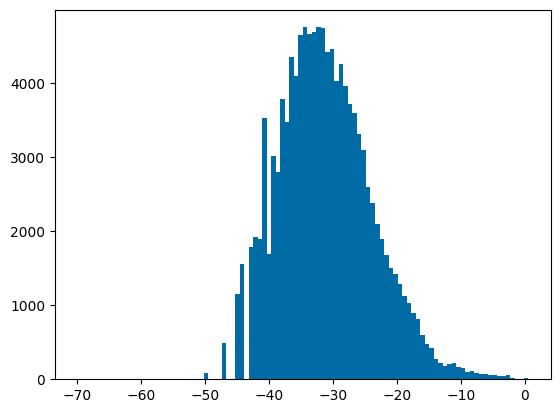

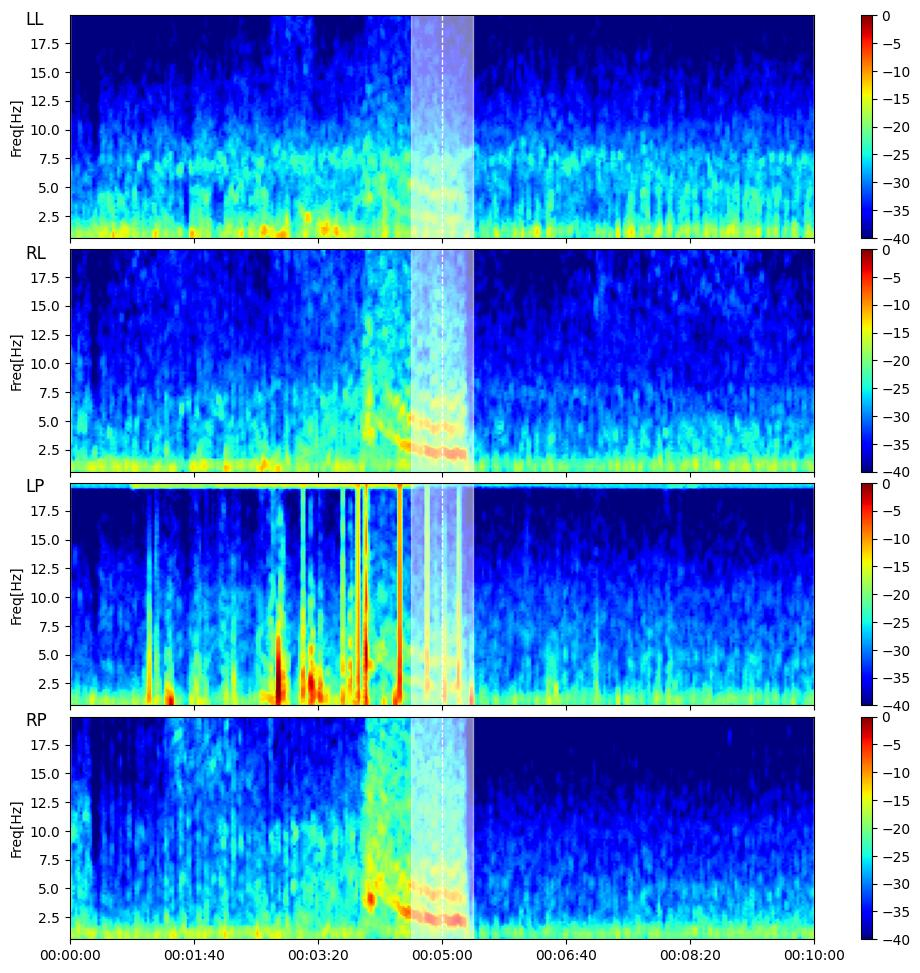

In [4]:
spectrogram = load_spectrogram(562780702, data_dir, "train")
x = map_log_scale(spectrogram)
plt.hist(x.ravel(), bins=100)
plt.show()
plot_spectrogram(spectrogram)

signals torch.Size([1, 2400])
spectrogram torch.Size([1, 128, 135])
extent (0, 54, 20, 0.6)


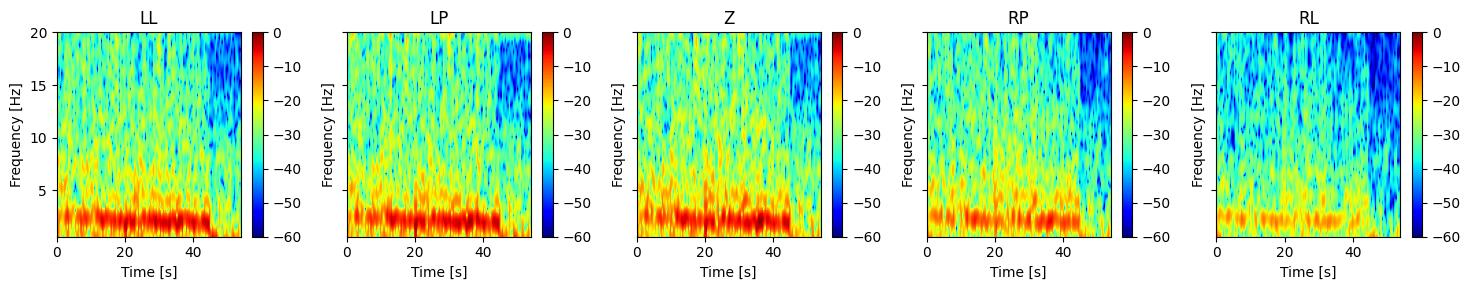

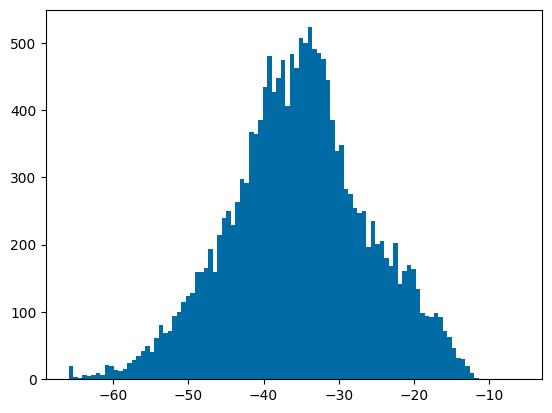

In [5]:
demo_spectrogram(900352951, data_dir, generation_mode="mean_of_probes")

signals torch.Size([4, 1, 2400])
spectrogram torch.Size([1, 128, 135])
extent (0, 54, 20, 0.6)


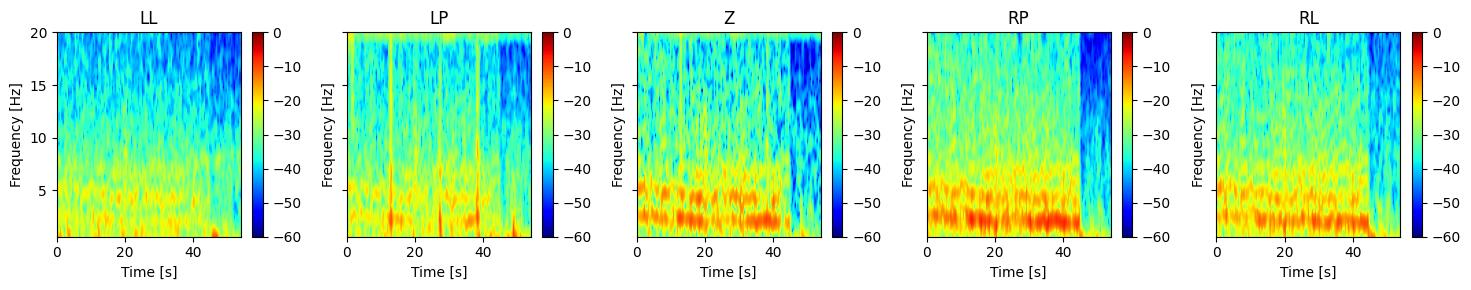

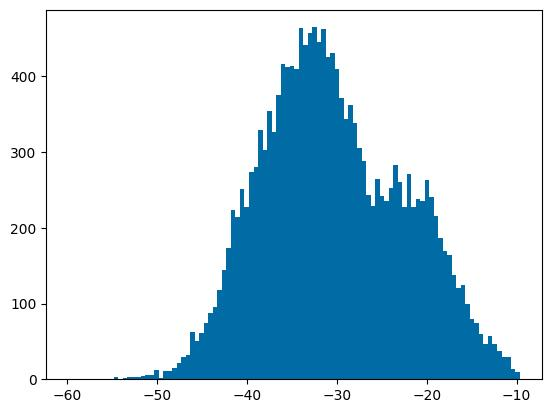

In [6]:
demo_spectrogram(900352951, data_dir, generation_mode="mean_of_probe_diffs")

電位差信号のspecの平均をとった図の方が電位の平均から生成したspecよりも、コンペで与えられているspecに近いように見える。
また、後者では信号の強度がGNDの電位の漂動を捉えてしまっており、LP,LLにおいて信号強度が大きいかのように見えてしまっている。
前者ではそのようなアーティファクトはなく、コンペデータにより近い。

signals torch.Size([4, 1, 8560])
spectrogram torch.Size([1, 128, 520])
extent (0, 208, 20, 0.6)


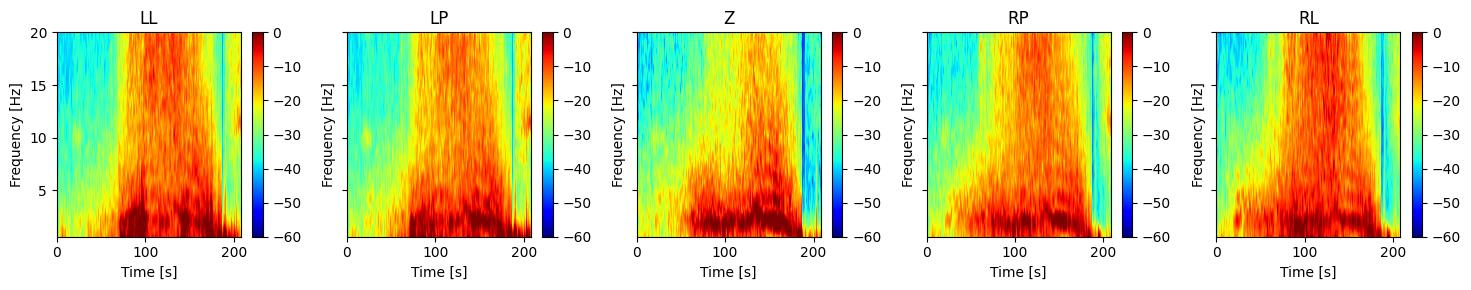

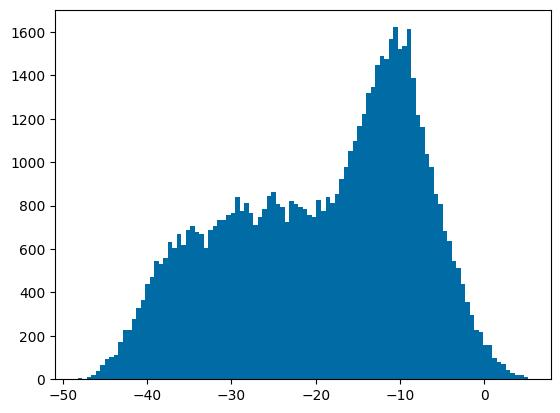

In [7]:
demo_spectrogram(3499508264, data_dir)

signals torch.Size([4, 1, 2240])
spectrogram torch.Size([1, 128, 125])
extent (0, 50, 20, 0.6)


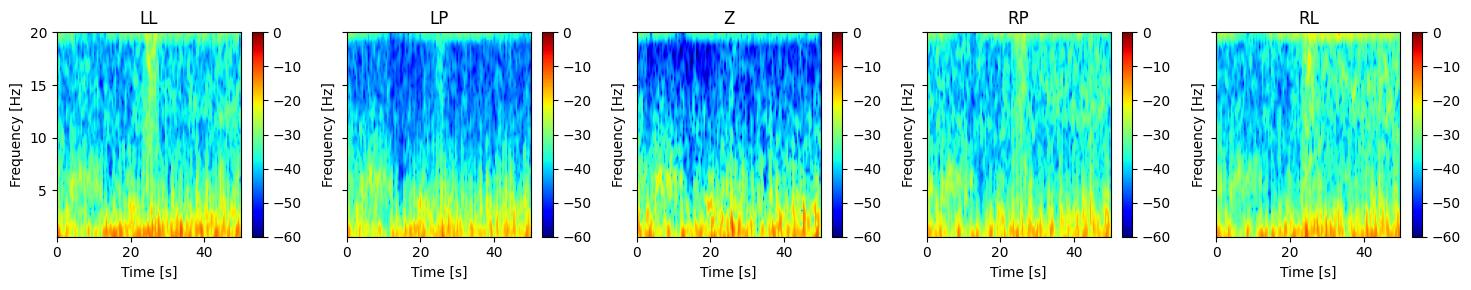

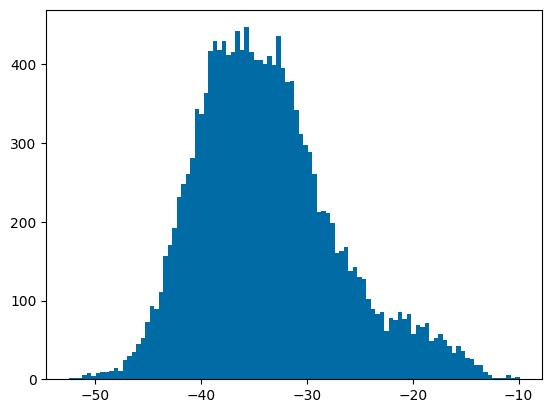

In [8]:
demo_spectrogram(2890591871, data_dir)

signals torch.Size([4, 1, 7280])
spectrogram torch.Size([1, 128, 440])
extent (0, 176, 20, 0.6)


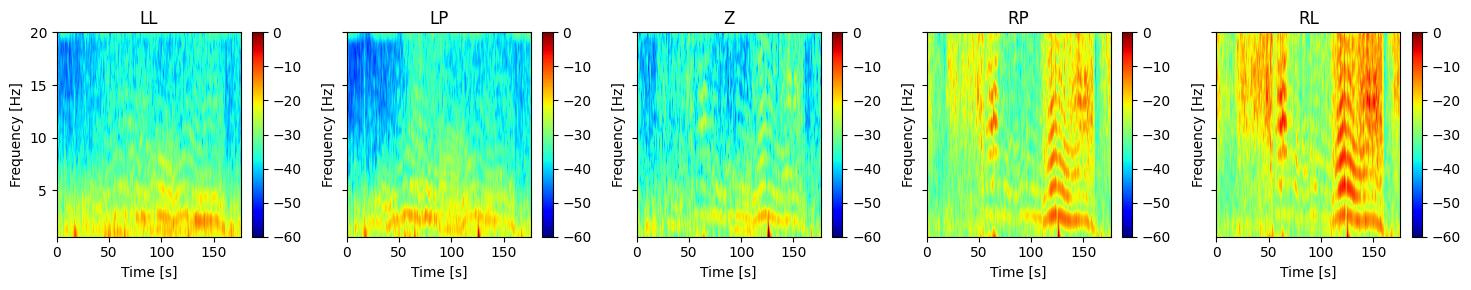

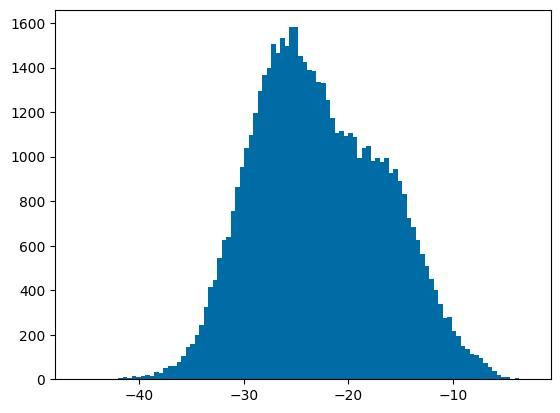

In [9]:
demo_spectrogram(2011795200, data_dir)

signals torch.Size([4, 1, 2320])
spectrogram torch.Size([1, 128, 130])
extent (0, 52, 20, 0.6)


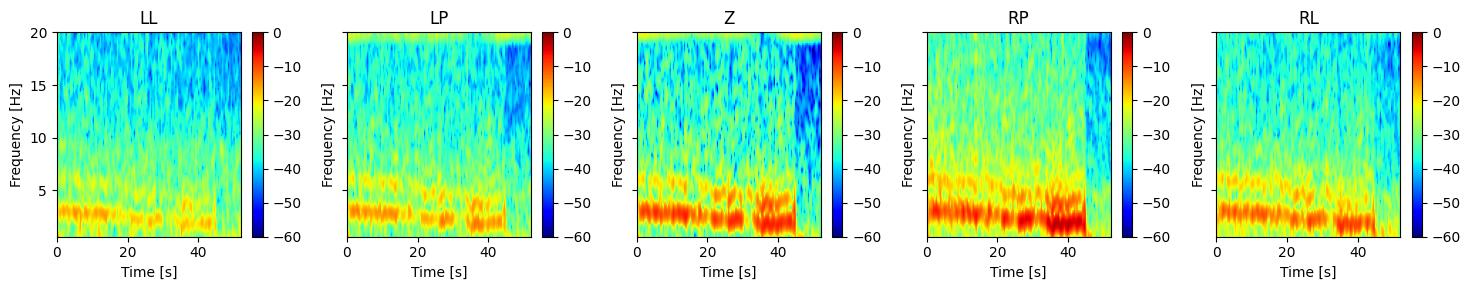

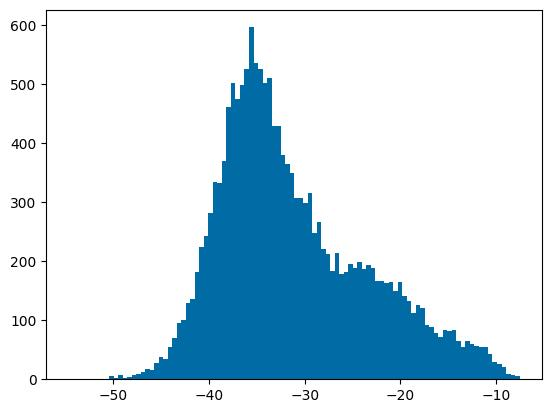

In [10]:
demo_spectrogram(4072555383, data_dir)

## LPD

signals torch.Size([4, 1, 4800])
spectrogram torch.Size([1, 128, 285])
extent (0, 114, 20, 0.6)


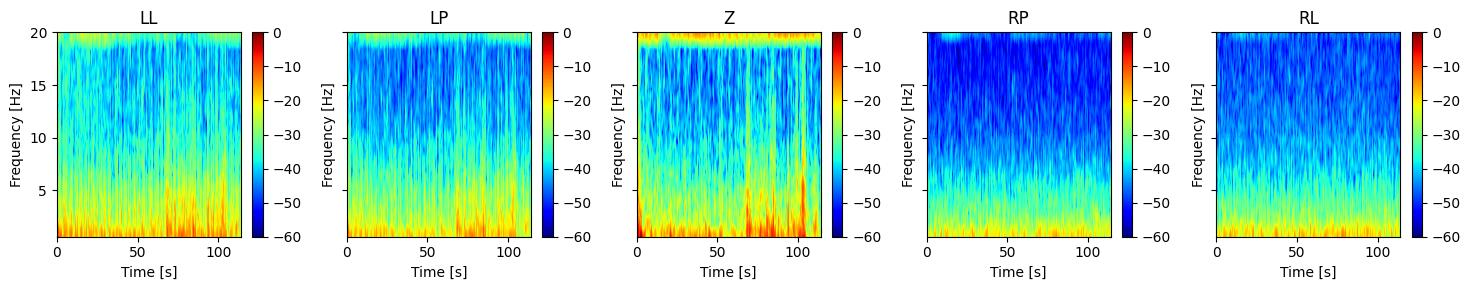

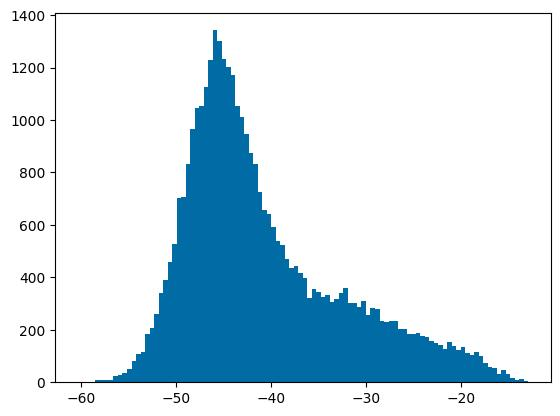

In [11]:
demo_spectrogram(1671017107, data_dir)

## GPD

signals torch.Size([4, 1, 13360])
spectrogram torch.Size([1, 128, 820])
extent (0, 328, 20, 0.6)


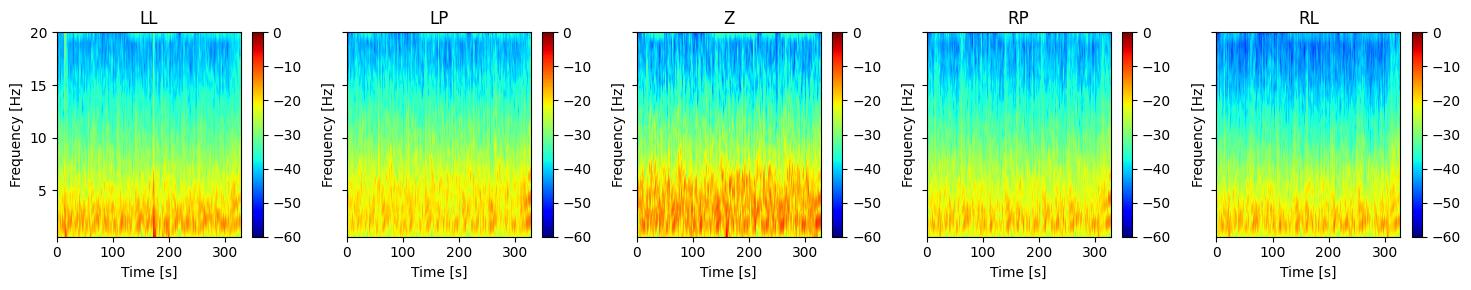

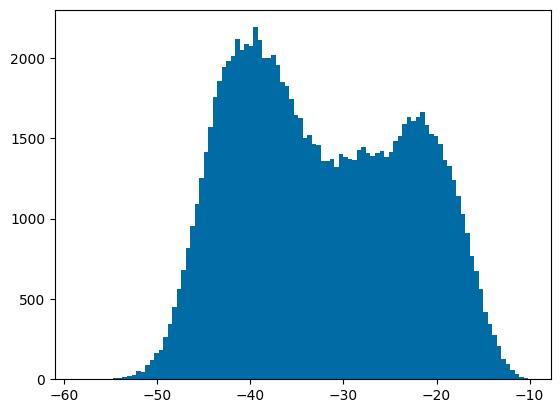

In [12]:
demo_spectrogram(1735972851, data_dir)

## LRDA

signals torch.Size([4, 1, 16880])
spectrogram torch.Size([1, 128, 1040])
extent (0, 416, 20, 0.6)


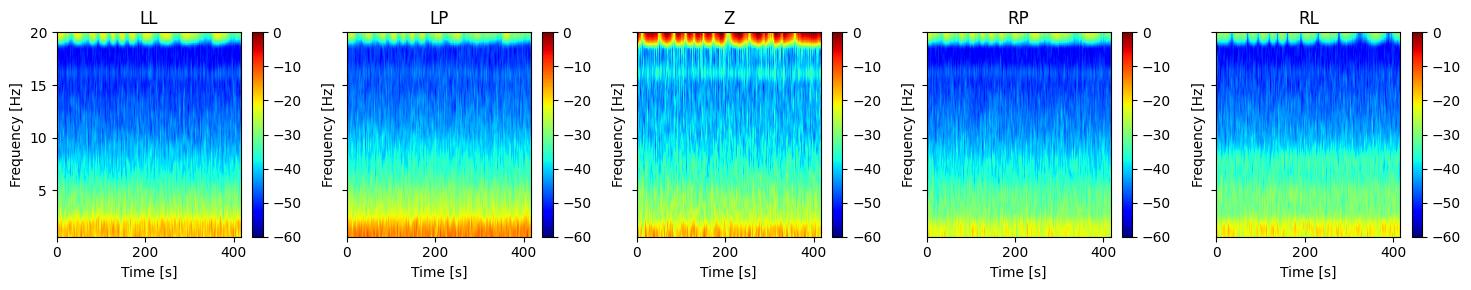

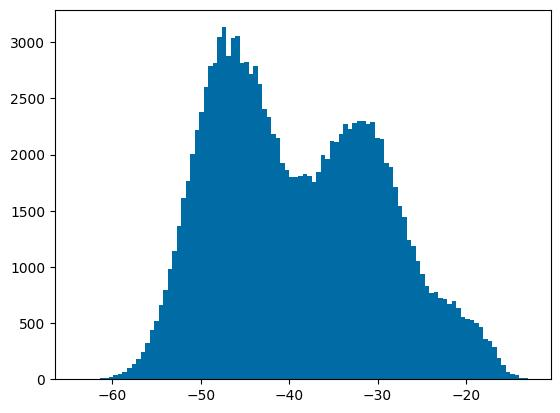

In [13]:
demo_spectrogram(21054661, data_dir)

## GRDA

signals torch.Size([4, 1, 20080])
spectrogram torch.Size([1, 128, 1240])
extent (0, 496, 20, 0.6)


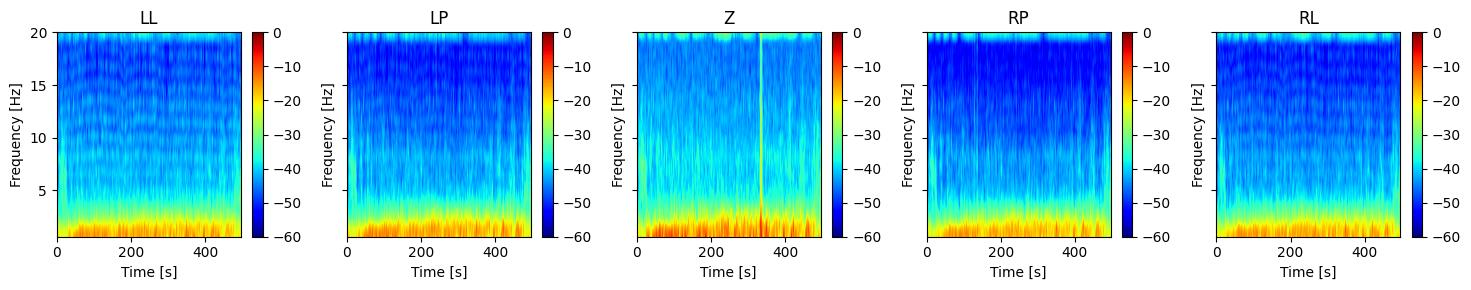

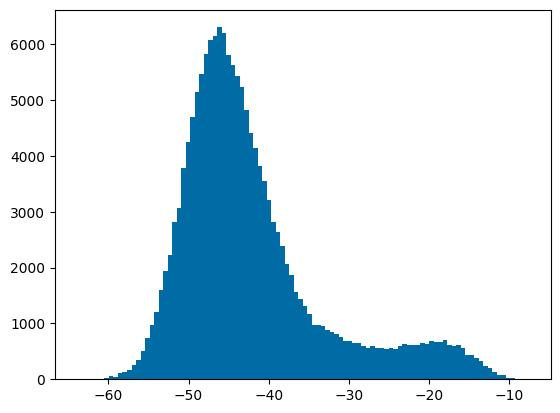

In [14]:
demo_spectrogram(3244743990, data_dir)

## Other

signals torch.Size([4, 1, 4080])
spectrogram torch.Size([1, 128, 240])
extent (0, 96, 20, 0.6)


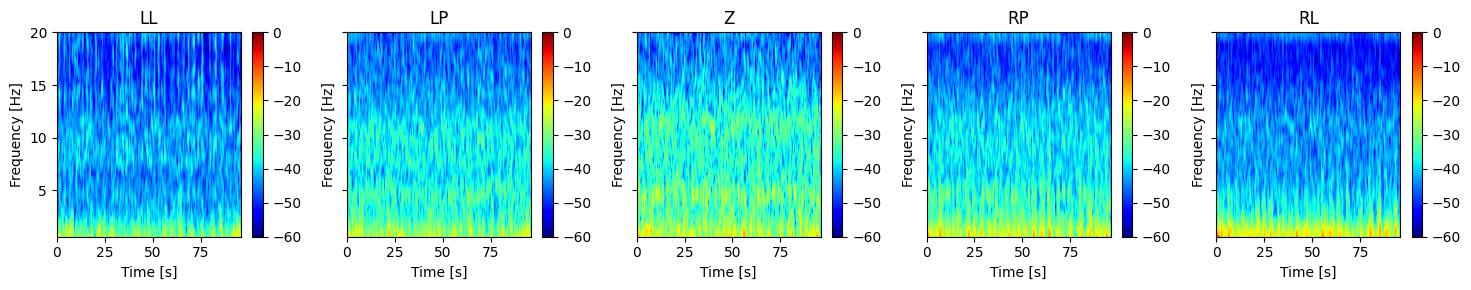

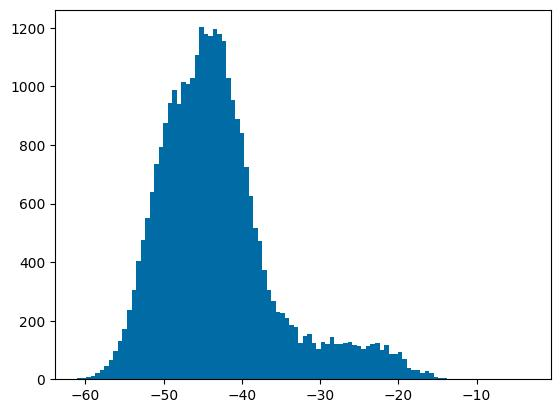

In [15]:
demo_spectrogram(3386837789, data_dir)

## 考察

- 20 Hz未満にしか意味のある信号は現れない。[0, 20Hz]の帯域の信号のみ見れば良い。
- spectrogramには1 Hz未満のピークが皆無なので、おそらくlow-pass filterをかけている。
- filterに入力する信号は値が[-1, 1]でないといけない（そうしないとclipされる）
- 平滑化しすぎると0-20Hzの波形が見えなくなる。w=5(200/5=40Hz)程度が妥当か。
- hop_lengthとwindow_lengthを異なる値にするとartifactができる
- window_lengthは400(2sec)以上に設定しないとseizure特有の紋様が見えない（これはartifactなのか？）

### 時間領域と周波数領域の分解能について

- PD/RDAの分類には時間方向のresolutionが有用かもしれない（intervalを検出するため）
- 一方で、seizureの検出には周波数方向のresolutionが有用かもしれない(周波数方向に一定間隔に出現する特徴的なパターンが見やすくなる)